In [49]:
import tensorflow as tf
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras import Model
from tensorflow.keras.experimental import LinearModel

In [46]:
%config Completer.use_jedi = False

In [2]:
# Uncomment the following to disable GPU
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Import parquet data

In [3]:
ds = pq.ParquetDataset("/var/log/fancontrol/featurelog")
ptable = ds.read().to_pandas()

In [315]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)
power = ptable['power'].apply(lambda a: clamp(a[0], 0.0, 99.0))

In [316]:
def feature_names():
    fn = list(ptable.columns.values)
    fn.remove('label')
    return fn

def generator_types():
    return ({k: tf.float32 for k in feature_names()}, tf.float32)

def generator_shapes():
    for index, row in ptable.iterrows():
        shapes = {}
        for k in feature_names():
            if isinstance(row[k], float) or isinstance(row[k], int):
                shapes[k] = tuple()
            else:
                shapes[k] = (len(row[k]),)
        return tuple([shapes, (1,)])

def generator():
    for index, row in ptable.iterrows():
        f = {k: tf.convert_to_tensor(row[k], tf.float32, name=k) for k in feature_names()}
        l = tf.convert_to_tensor(list([float(row['label'])]), tf.float32, name='label')
        yield f, l

In [278]:
generator_types()

({'timestamp': tf.float32,
  'cpuinfo': tf.float32,
  'profile': tf.float32,
  'cpu_idle': tf.float32,
  'cpu_user': tf.float32,
  'cpu_system': tf.float32,
  'cpu_nice': tf.float32,
  'power_constraints': tf.float32,
  'power': tf.float32,
  'temp': tf.float32,
  'fan_rpm': tf.float32,
  'year': tf.float32,
  'month': tf.float32,
  'day': tf.float32},
 tf.float32)

In [293]:
generator_shapes()

({'timestamp': (),
  'cpuinfo': (8,),
  'profile': (1,),
  'cpu_idle': (8,),
  'cpu_user': (8,),
  'cpu_system': (8,),
  'cpu_nice': (8,),
  'power_constraints': (2,),
  'power': (1,),
  'temp': (10,),
  'fan_rpm': (1,),
  'year': (),
  'month': (),
  'day': ()},
 (1,))

In [317]:
all = tf.data.Dataset.from_generator(generator, output_types=generator_types(), output_shapes=generator_shapes()) \
    .shuffle(10, reshuffle_each_iteration=False)

In [319]:
n = next(all.batch(2).as_numpy_iterator())

In [320]:
print(n)

({'timestamp': array([1.6376166e+09, 1.6376166e+09], dtype=float32), 'cpuinfo': array([[2800.   , 2800.   , 2800.   , 1898.875, 2800.   , 2800.   ,
        2800.   , 2800.   ],
       [2800.   , 2800.   , 2762.186, 2800.   , 2800.   , 2800.   ,
        2800.   , 2800.   ]], dtype=float32), 'profile': array([[1.],
       [1.]], dtype=float32), 'cpu_idle': array([[0.9861111 , 0.9577465 , 0.9027778 , 0.9104478 , 0.9701493 ,
        1.        , 0.942029  , 0.9859155 ],
       [0.96666664, 0.9655172 , 0.9310345 , 0.88461536, 1.        ,
        1.        , 0.96666664, 0.96666664]], dtype=float32), 'cpu_user': array([[0.01388889, 0.02816901, 0.05555556, 0.01492537, 0.        ,
        0.        , 0.01449275, 0.01408451],
       [0.03333334, 0.03448276, 0.03448276, 0.        , 0.        ,
        0.        , 0.03333334, 0.03333334]], dtype=float32), 'cpu_system': array([[0.        , 0.01408451, 0.04166667, 0.07462686, 0.02985075,
        0.        , 0.04347826, 0.        ],
       [0.        

In [321]:
tf.shape(n[0]['temp']).numpy()

array([ 2, 10], dtype=int32)

In [322]:
tf.shape(n[1]).numpy()

array([2, 1], dtype=int32)

In [323]:
#for k in n[0]:
#    print(str(k) + " -> " + str(tf.shape(n[0][k])))

In [324]:
def is_test(x, y):
    return x % 4 == 0
def is_train(x, y):
    return not is_test(x, y)
recover = lambda x,y: y
test_dataset = all.enumerate() \
                    .filter(is_test) \
                    .map(recover)

train_dataset = all.enumerate() \
                    .filter(is_train) \
                    .map(recover)

# Lets build a simple model

In [325]:
from tensorflow.keras import layers
from tensorflow import keras

In [334]:
#temp_input = Input(shape=(10,), name="temp")
power_input = Input(shape=(1,), name="power")
all_input = [power_input]#, temp_input]

In [335]:
x = layers.concatenate(all_input)

In [336]:
fanlevel_output = Dense(1, name="level")(x)

In [337]:
linear_model=keras.Model(inputs=all_input, outputs=[fanlevel_output])
linear_model.compile(optimizer='adam', loss='mse')

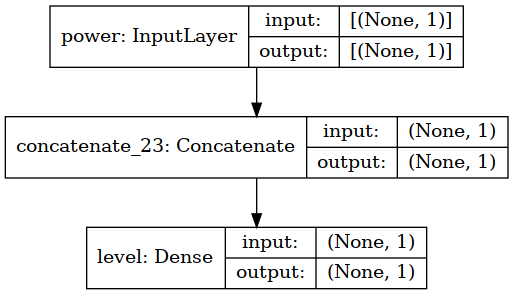

In [338]:
keras.utils.plot_model(linear_model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
linear_model.fit(train_dataset, epochs=1, batch_size=32)

/home/danielk/.pyenv/versions/3.6.11/envs/smart-fancontrol/lib/python3.6/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['timestamp', 'cpuinfo', 'profile', 'cpu_idle', 'cpu_user', 'cpu_system', 'cpu_nice', 'power_constraints', 'temp', 'fan_rpm', 'year', 'month', 'day'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


 671669/Unknown - 1178s 2ms/step - loss: 1046.4331